In [24]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, \
recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

%matplotlib inline

# Preprocessing

In [2]:
# import data
phys = pd.read_csv('../physicians.csv')
# phys.info()

proc = pd.read_csv('../procedures.csv')
# proc.info()

# Get all the distinct procedure codes and use them to create LabelBinarizer 
proc_code_list = sorted(proc['procedure_code'].unique())
proc_label_binarizer = LabelBinarizer(sparse_output=False)
proc_label_binarizer.fit(proc_code_list)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [3]:
# split phsician data into unknown and known

# Get unknown index
_choose = ['Unknown' in specialty for specialty in phys['specialty']]
phys_unknown = phys[_choose]
phys_known = phys[[not ii for ii in _choose]]

# phys_unknown.info()

In [4]:
# This function forms the feature matrix
# Features are all procedures expressed in a vector taking binary binary values on each procedure (True/False)
def extract_features(phys):
    X = []
    for nrow, physician_id in enumerate(phys['id']):
        # get all the procedures conduced by a physician
        _proc = proc[proc['physician_id'] == physician_id]['procedure_code']
        # binarizing
        _bin = proc_label_binarizer.transform(_proc.values)
        # Take vertical sum to form a feature vector and append to X
        X.append(_bin.sum(axis=0))
    
    return np.asarray(X)

X = extract_features(phys_known)

In [8]:
# Form the target vector (y)
def extract_targets(phys):
    return (phys['specialty'] == 'Cardiology').values

y = extract_targets(phys_known)

In [9]:
# Stratified shuffle-split into train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]
    
    X_test = X[test_index,:]
    y_test = y[test_index]

# Modeling

In [10]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [11]:
cross_val_score(forest_clf, X_train, y_train, cv=5, scoring="accuracy")

array([ 0.96966658,  0.97192279,  0.97568313,  0.9716721 ,  0.97266115])

In [13]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=5)

# calculate confusion matrix

print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_pred))
print("Precision Score: ", precision_score(y_train, y_train_pred))
print("Recall Score: ", recall_score(y_train, y_train_pred))
print("F1 Score: ", f1_score(y_train, y_train_pred))

Confusion Matrix: 
 [[13117   207]
 [  345  6274]]
Precision Score:  0.968060484493
Recall Score:  0.947877322858
F1 Score:  0.95786259542


# Presicion/Recall Tradeoff


In [18]:
# Precision/Recall tradeoff

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=5, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

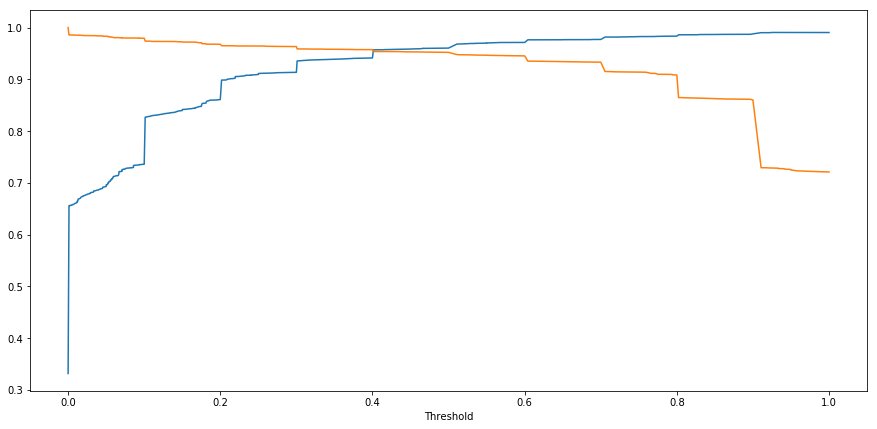

In [19]:
plt.figure(figsize=(15,7))
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])
plt.xlabel('Threshold')

# The Receiver Operating Characteristic Curve

In [21]:
# The ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores_forest)

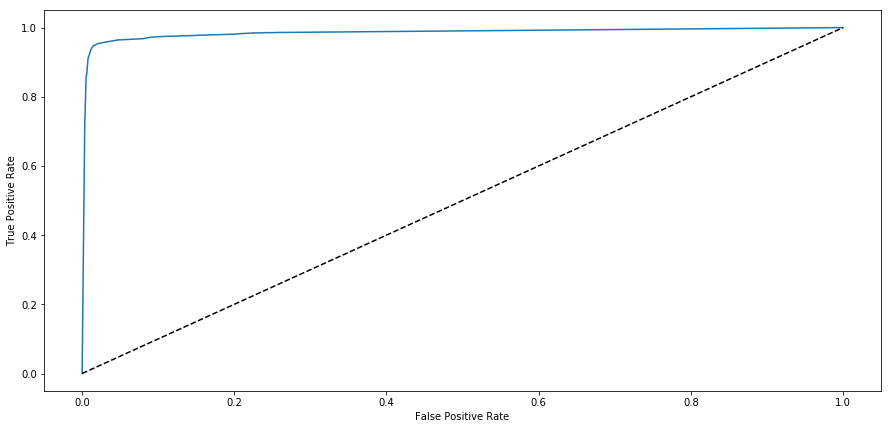

In [22]:
plt.figure(figsize=(15,7))
plt.plot(fpr, tpr)
plt.plot([0, 1],[0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [26]:
roc_auc_score(y_train, y_scores_forest)

0.98515118045995231

# Evaluate on Test Set

In [28]:
y_test_pred = forest_clf.predict(X_test)

In [29]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score
print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred))
print("Precision Score: ", precision_score(y_test, y_test_pred))
print("Recall Score: ", recall_score(y_test, y_test_pred))
print("F1 Score: ", f1_score(y_test, y_test_pred))

Confusion Matrix: 
 [[3276   55]
 [  88 1567]]
Precision Score:  0.966091245376
Recall Score:  0.946827794562
F1 Score:  0.956362526701


# Prediction on the 'Unkown'

In [30]:
X_ = extract_features(phys_unknown)

In [33]:
y_unknown_pred = forest_clf.predict(X_)
print("Number of carodiologists found: ", y_unknown_pred.sum())

print(y_unknown_pred.sum()/len(y_unknown_pred))

Number of carodiologists found:  3631
0.327235039654
